In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="ueXyEv17PLtUVkhqSqYu")
project = rf.workspace("kritsakorn").project("acne-kbm0q")
version = project.version(21)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!pip install tensorflow opencv-python matplotlib scikit-learn

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [ ]:
train_image_dir = 'Acne-21/train/images'
train_label_dir = 'Acne-21/train/labels'
val_image_dir = 'Acne-21/valid/images'
val_label_dir = 'Acne-21/valid/labels'

In [ ]:
def data_generator(image_dir, label_dir, batch_size, num_classes, image_size=(64, 64)):
    while True:
        image_files = os.listdir(image_dir)
        np.random.shuffle(image_files)  # Shuffle for randomness

        # Initialize lists for valid batches
        images = []
        labels = []

        for image_name in image_files:
            # Load and preprocess image
            image_path = os.path.join(image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"Image {image_name} not found, skipping.")
                continue

            image = Image.open(image_path).resize(image_size)
            images.append(np.array(image) / 255.0)  # Normalize pixel values

            # Load corresponding label
            label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))
            if not os.path.exists(label_path):
                print(f"Label for {image_name} not found, skipping.")
                images.pop()  # Remove the image if the label is missing
                continue

            with open(label_path, 'r') as f:
                label_data = f.readlines()
                if label_data:  # Check if label_data is not empty
                    class_id = int(label_data[0].split()[0])  # Extract class ID
                    if 0 <= class_id < num_classes:  # Only append valid labels
                        labels.append(to_categorical(class_id, num_classes))
                    else:
                        print(f"Invalid class ID for {image_name}, skipping.")
                        images.pop()  # Remove the image if label is invalid
                else:
                    print(f"Label file for {image_name} is empty. Skipping.")
                    images.pop()  # Remove the image if the label is empty

            # Yield batch when it's full
            if len(images) == batch_size and len(labels) == batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []  # Reset for the next batch

        # If any remaining images and labels are left, yield them as well
        if len(images) == len(labels) and images and labels:
            print(f"Yielding final batch of size {len(images)}")
            yield np.array(images), np.array(labels)

In [ ]:
from tensorflow.keras import layers, models

def create_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(64, 64, 3)),  # Define the input shape here
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

class_names = ['blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads']
# Create and compile the model
num_classes = len(class_names)
model = create_model(num_classes)


In [ ]:
# Parameters
batch_size = 16

# Create generators
train_gen = data_generator(train_image_dir, train_label_dir, batch_size, 6)
val_gen = data_generator(val_image_dir, val_label_dir, batch_size, 6)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


def display_labeled_images(image_dir, label_dir, num_samples=4, image_size=(255, 255)):
    plt.figure(figsize=(15, 10))

    # Randomly select sample images
    sample_images = np.random.choice(os.listdir(image_dir), num_samples)

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)

        # Resize the image for visualization purposes (if needed)
        image_resized = cv2.resize(image, image_size)

        # Load corresponding label file
        label_file = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    label = list(map(float, line.strip().split()))
                    class_label = int(label[0])  # Acne type
                    x_center, y_center, box_width, box_height = label[1:]

                    # Convert normalized coordinates to pixel values
                    x_center_px = int(x_center * image_size[0])
                    y_center_px = int(y_center * image_size[1])
                    box_width_px = int(box_width * image_size[0])
                    box_height_px = int(box_height * image_size[1])

                    # Calculate top-left corner of the bounding box
                    x1 = int(x_center_px - box_width_px / 2)
                    y1 = int(y_center_px - box_height_px / 2)

                    # Draw bounding box on the image
                    cv2.rectangle(image_resized, (x1, y1),
                                  (x1 + box_width_px, y1 + box_height_px),
                                  color=(255, 0, 0), thickness=1)

                    # Optional: Add class label text
                    cv2.putText(image_resized, str(class_label), (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

            # Display the image with bounding boxes
            plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
            plt.title(f"Class: {class_label}")
        else:
            plt.title("No label found")

    plt.show()

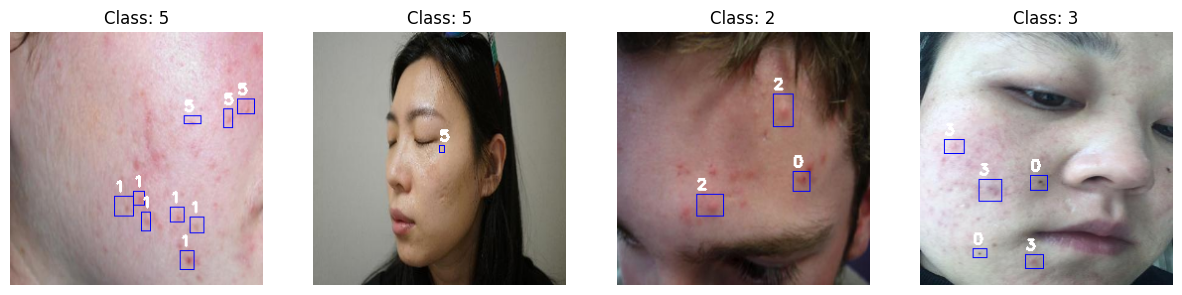

In [ ]:
# Display samples from training data
display_labeled_images(train_image_dir, train_label_dir)

# Or for validation data
# display_samples(val_image_dir, val_label_dir, num_samples=5)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,358 (2.49 MB)

 Trainable params: 652,358 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_names = [layer.name for layer in model.layers if isinstance(layer, layers.Dense)]
print(output_names)


['dense_4', 'dense_5']


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

# Create an instance of EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Parameters
epochs = 20  # Adjust the number of epochs as needed
batch_size = 32  # You can adjust the batch size as needed

# Calculate steps per epoch
train_steps = len(os.listdir(train_image_dir)) // batch_size
val_steps = len(os.listdir(val_image_dir)) // batch_size

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


# Fit the model using the data generator
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[reduce_lr,early_stopping])


Epoch 1/10
 2/30 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.2812 - loss: 1.5506Yielding final batch of size 6
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3234 - loss: 1.5800Label file for levle1_106_jpg.rf.f0f0c8fa8104484895715280e64f0593.jpg is empty. Skipping.
Label file for levle2_111_jpg.rf.5f57948f8a8e5fff71360f05e3b02565.jpg is empty. Skipping.
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3237 - loss: 1.5789 - val_accuracy: 0.3125 - val_loss: 1.5368 - learning_rate: 2.0000e-04
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.3203 - loss: 1.5489Yielding final batch of size 2
Label file for levle1_106_jpg.rf.f0f0c8fa8104484895715280e64f0593.jpg is empty. Skipping.
Label file for levle2_111_jpg.rf.5f57948f8a8e5fff71360f05e3b02565.jpg is empty. Skipping.
Label file for levle3_81_jpg.rf.8a37f5303c2aedf18fa8730121137afc.jpg is empty. Skipping.
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.3199 - loss: 1.5496 - val_accuracy: 0.3293 - 

In [ ]:
model.save('image_classifier_model.h5')


In [ ]:
!pip install roboflow


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Acne-21 in yolov11:: 100%|██████████| 2522/2522 [00:00<00:00, 3349.43it/s]


In [ ]:
import shutil

shutil.rmtree('/content/Acne-21')

In [ ]:
pwd

'/content'